# Семинар 7
# Метод сопряжённых градиентов (Conjugate gradient method)
# Метод тяжёлого шарика 
# Ускоренный градиентный метод

## На прошлом семинаре

1. Общие сведения о численных методах оптимизации
2. Скорость сходимости
3. Методы спуска
4. Спообы выбора шага
5. Градиентный спуск

## Система линейных уравнений vs. задача безусловной минимизации
Рассмотрим задачу
$$
\min_{x \in \mathbb{R}^n} \frac{1}{2}x^{\top}Ax - b^{\top}x,
$$
где $A \in \mathbb{S}^n_{++}$.
Из необходимого условия экстремума имеем
$$
Ax^* = b
$$
Также обозначим $f'(x_k) = Ax_k - b = r_k$

## Как решить систему $Ax = b$?

- Прямые методы основаны на матричных разложениях:
    - Плотная матрица $A$: для размерностей не больше нескольких тысяч
    - Разреженная (sparse) матрица $A$: для размерностей порядка $10^4 - 10^5$
- Итерационные методы: хороши во многих случаях, единственный подход для задач с размерностью $ > 10^6$

## Метод сопряжённых направлений

В градиентном спуске направления убывания - анти-градиенты, но для функций с плохо обусловленным гессианом сходимость **медленная**.

**Идея:** двигаться вдоль направлений, которые гарантируют сходимость за $n$ шагов.

**Определение.** Множество ненулевых векторов $\{p_0, \ldots, p_l\}$ называется *сопряжённым* относительно матрицы $A \in \mathbb{S}^n_{++}$, если 
$$
p^{\top}_iAp_j = 0, \qquad i \neq j
$$

**Пример**: собственные векторы матрицы $A$

**Утверждение.** Для любой $x_0 \in \mathbb{R}^n$ последовательность $\{x_k\}$, генерируемая методом сопряжённых направлений, сходится к решению системы $Ax = b$ максимум за $n$ шагов.

```python
def ConjugateDirections(x0, A, b, p):
    x = x0
    r = A.dot(x) - b
    for i in xrange(len(p)):
        alpha = - (r.dot(p[i])) / (p[i].dot(A.dot(p[i])))
        x = x + alpha * p[i]
        r = A.dot(x) - b
    return x
```

### Геометрическая интерпретация ([лекция Gilbert'a Strang'a](http://math.mit.edu/classes/18.086/2006/am64.pdf))

<center><img src="./cg_vs_gd.png" ></center>

## Метод сопряжённых градиентов

**Идея:** новое направление $p_k$ ищется в виде $p_k = -r_k + \beta_k p_{k-1}$, где $\beta_k$ выбирается, исходя из требования сопряжённости $p_k$ и $p_{k-1}$:
$$
\beta_k = \dfrac{p^{\top}_{k-1}Ar_k}{p^{\top}_{k-1}Ap^{\top}_{k-1}}
$$
Таким образом, для получения следующего сопряжённого направления $p_k$ необходимо хранить только сопряжённое направление $p_{k-1}$ и остаток $r_k$ с предыдущей итерации. 

**Вопрос:** как находить размер шага $\alpha_k$?

### Теоремы сходимости

**Теорема 1.** Если матрица $A$ имеет только $r$ различных собственных значений, то метод сопряжённых градиентов cойдётся за $r$ итераций.

**Теорема 2.** Имеет место следующая оценка сходимости
$$
\| x_{k+1} - x^* \|_A \leq \left( \dfrac{\sqrt{\kappa(A)} - 1}{\sqrt{\kappa(A)} + 1} \right)^k \|x_0 - x^*\|_A,
$$
где $\|x\|_A = x^{\top}Ax$ и $\kappa(A) = \frac{\lambda_n(A)}{\lambda_1(A)}$ - число обусловленности матрицы $A$

**Замечание:** сравните коэффициент геометрической прогрессии с аналогом в градиентном спуске.

### Интерпретации метода сопряжённых градиентов

- Градиентный спуск в пространстве $y = Sx$, где $S = [p_0, \ldots, p_n]$, в котором матрица $A$ становится диагональной (или единичной в случае ортонормированности сопряжённых направлений)
- Поиск оптимального решения в [Крыловском подпространстве](https://stanford.edu/class/ee364b/lectures/conj_grad_slides.pdf) $\mathcal{K}(A) = \{b, Ab, A^2b, \ldots \}$

### Улучшенная версия метода сопряжённых градиентов
На практике используются следующие формулы для шага $\alpha_k$ и коэффициента $\beta_{k}$:
$$
\alpha_k = \dfrac{r^{\top}_k r_k}{p^{\top}_{k}Ap_{k}} \qquad \beta_k = \dfrac{r^{\top}_k r_k}{r^{\top}_{k-1} r_{k-1}}
$$
**Вопрос:** чем они лучше базовой версии?

### Псевдокод метода сопряжённых градиентов
```python
def ConjugateGradientQuadratic(x0, A, b):
    r = A.dot(x0) - b
    p = -r
    while np.linalg.norm(r) != 0:
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        r_next = r + alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = -r_next + beta * p
        r = r_next
    return x
```

## Метод сопряжённых градиентов для неквадратичной функции
**Идея:** использовать градиенты $f'(x_k)$ неквадратичной функции вместо остатков $r_k$ и линейный поиск шага $\alpha_k$ вместо аналитического вычисления. Получим метод Флетчера-Ривса.

```python
def ConjugateGradientFR(f, gradf, x0):
    x = x0
    grad = gradf(x)
    p = -grad
    while np.linalg.norm(gradf(x)) != 0:
        alpha = StepSearch(x, f, gradf, **kwargs)
        x = x + alpha * p
        grad_next = gradf(x)
        beta = grad_next.dot(grad_next) / grad.dot(grad)
        p = -grad_next + beta * p
        grad = grad_next
        if restart_condition:
            p = -gradf(x)
    return x
```

### Теорема сходимости

**Теорема.** Пусть 
- множество уровней $\mathcal{L}$ ограничено
- существует $\gamma > 0$: $\| f'(x) \|_2 \leq \gamma$ для $x \in \mathcal{L}$
Тогда
$$
\lim_{j \to \infty} \| f'(x_{k_j}) \|_2 = 0
$$

### Перезапуск (restart)

1. Для ускорения метода сопряжённых градиентов используют технику перезапусков: удаление ранее накопленной истории и перезапуск метода с текущей точки, как будто это точка $x_0$
2. Существуют разные условия, сигнализирующие о том, что надо делать перезапуск, например
    - $k = n$
    - $\dfrac{|\langle f'(x_k), f'(x_{k-1}) \rangle |}{\| f'(x_k) \|_2^2} \geq \nu \approx 0.1$
3. Можно показать (см. Nocedal, Wright Numerical Optimization, Ch. 5, p. 125), что запуск метода Флетчера-Ривза без использования перезапусков на некоторых итерациях может приводить к крайне медленной сходимости! 
4. Метод Полака-Рибьера и его модификации лишены подобного недостатка.

### Комментарии
- Замечательная методичка "An Introduction to the Conjugate Gradient Method Without the Agonizing Pain" размещена [тут](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf)
- Помимо метода Флетчера-Ривса существуют другие способы вычисления $\beta_k$: метод Полака-Рибьера, метод Хестенса-Штифеля...
- Для метода сопряжённых градиентов требуется 4 вектора: каких?
- Самой дорогой операцией является умножение матрицы на вектор

## Эксперименты


### Квадратичная целевая функция

In [37]:
import numpy as np
n = 100
# Random
# A = np.random.randn(n, n)
# A = A.T.dot(A)
# Clustered eigenvalues
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
print("A is normal matrix: ||AA* - A*A|| =", np.linalg.norm(A.dot(A.T) - A.T.dot(A)))
b = np.random.rand(n)
# Hilbert matrix
# A = np.array([[1.0 / (i+j - 1) for i in range(1, n+1)] for j in range(1, n+1)])
# b = np.ones(n)

f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

A is normal matrix: ||AA* - A*A|| = 0.0


#### Распределение собственных значений

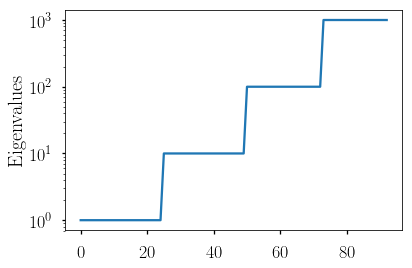

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
plt.rc("font", family='serif')
import seaborn as sns
sns.set_context("talk")

eigs = np.linalg.eigvalsh(A)
plt.semilogy(np.unique(eigs))
plt.ylabel("Eigenvalues", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.tight_layout()

#### Правильный ответ

In [39]:
import scipy.optimize as scopt

def callback(x, array):
    array.append(x)

In [40]:
scopt_cg_array = []
scopt_cg_callback = lambda x: callback(x, scopt_cg_array)
x = scopt.minimize(f, x0, method="CG", jac=grad_f, callback=scopt_cg_callback)
x = x.x
print("||f'(x*)|| =", np.linalg.norm(A.dot(x) - b))
print("f* =", f(x))

||f'(x*)|| = 1.0174511621391754e-08
f* = -10.338964702100567


#### Реализация метода сопряжённых градиентов

In [41]:
def ConjugateGradientQuadratic(x0, A, b, tol=1e-8, callback=None):
    x = x0
    r = A.dot(x0) - b
    p = -r
    while np.linalg.norm(r) > tol:
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        if callback is not None:
            callback(x)
        r_next = r + alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = -r_next + beta * p
        r = r_next
    return x

In [42]:
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

print("\t CG quadratic")
cg_quad = methods.fo.ConjugateGradientQuad(A, b)
x_cg = cg_quad.solve(x0, tol=1e-7, disp=True)

print("\t Gradient Descent")
gd = methods.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b))
x_gd = gd.solve(x0, tol=1e-7, disp=True)

print("Condition number of A =", abs(max(eigs)) / abs(min(eigs)))

	 CG quadratic
Required tolerance achieved!
Convergence in 4 iterations
Function value = -10.338964702100506
Norm of gradient = 5.2070366410515865
	 Gradient Descent
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -8.05146204799006
Norm of gradient = 7.982024151646561
Condition number of A = 1000.0000000006659


#### График сходимости

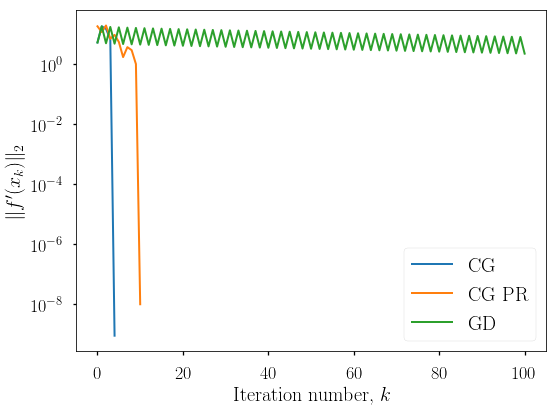

In [43]:
plt.figure(figsize=(8,6))
plt.semilogy([np.linalg.norm(grad_f(x)) for x in cg_quad.get_convergence()], label=r"CG", linewidth=2)
plt.semilogy([np.linalg.norm(grad_f(x)) for x in scopt_cg_array], label=r"CG PR", linewidth=2)
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label=r"GD", linewidth=2)
plt.legend(loc="best", fontsize=20)
plt.xlabel(r"Iteration number, $k$", fontsize=20)
plt.ylabel(r"$\|f'(x_k)\|_2$", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.tight_layout()

In [44]:
print([np.linalg.norm(grad_f(x)) for x in cg_quad.get_convergence()])

[5.2070366410515865, 18.014860535603315, 14.785168028959406, 6.732852224332724, 9.14655313749854e-10]


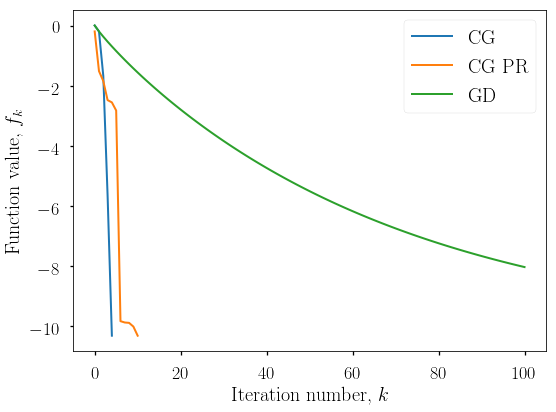

In [45]:
plt.figure(figsize=(8,6))
plt.plot([f(x) for x in cg_quad.get_convergence()], label=r"CG", linewidth=2)
plt.plot([f(x) for x in scopt_cg_array], label=r"CG PR", linewidth=2)
plt.plot([f(x) for x in gd.get_convergence()], label=r"GD", linewidth=2)
plt.legend(loc="best", fontsize=20)
plt.xlabel(r"Iteration number, $k$", fontsize=20)
plt.ylabel(r"Function value, $f_k$", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("./cg_gd_plot_f.pdf",format="pdf")

### Неквадратичная функция

In [46]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1
def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]
# f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
# grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 2.0786735893646457


#### Реализация метода Флетчера-Ривса

In [47]:
def ConjugateGradientFR(f, gradf, x0, num_iter=100, tol=1e-8, callback=None, restart=False):
    x = x0
    grad = gradf(x)
    p = -grad
    it = 0
    while np.linalg.norm(gradf(x)) > tol and it < num_iter:
        alpha = utils.backtracking(x, p, method="Wolfe", beta1=0.1, beta2=0.4, rho=0.5, f=f, grad_f=gradf)
        if alpha < 1e-18:
            break
        x = x + alpha * p
        if callback is not None:
            callback(x)
        grad_next = gradf(x)
        beta = grad_next.dot(grad_next) / grad.dot(grad)
        p = -grad_next + beta * p
        grad = grad_next.copy()
        it += 1
        if restart and it % restart == 0:
            grad = gradf(x)
            p = -grad
    return x

#### График сходимости

In [67]:
import scipy.optimize as scopt
import liboptpy.restarts as restarts

n_restart = 100
tol = 1e-5
max_iter = 600

scopt_cg_array = []
scopt_cg_callback = lambda x: callback(x, scopt_cg_array)
x = scopt.minimize(f, x0, tol=tol, method="CG", jac=grad_f, callback=scopt_cg_callback, options={"maxiter": max_iter})
x = x.x
print("\t CG by Polak-Rebiere")
print("Norm of garient = {}".format(np.linalg.norm(grad_f(x))))
print("Function value = {}".format(f(x)))

print("\t CG by Fletcher-Reeves")
cg_fr = methods.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe", rho=0.5, beta1=0.01, beta2=0.9, init_alpha=1.))
x = cg_fr.solve(x0, tol=tol, max_iter=max_iter, disp=True)

print("\t CG by Fletcher-Reeves with restart n")
cg_fr_rest = methods.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe", rho=0.5, beta1=0.01, beta2=0.9, 
                                         init_alpha=1.), restarts.Restart(n // n_restart))
x = cg_fr_rest.solve(x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Gradient Descent")
gd = methods.fo.GradientDescent(f, grad_f, ss.Backtracking("Wolfe", rho=0.5, beta1=0.01, beta2=0.9, init_alpha=1.))
x = gd.solve(x0, max_iter=max_iter, tol=tol, disp=True)

	 CG by Polak-Rebiere
Norm of garient = 1.6466331166004082e-05
Function value = 0.48747453954295017
	 CG by Fletcher-Reeves
Required tolerance achieved!
Convergence in 53 iterations
Function value = 0.48747453950775055
Norm of gradient = 7.124040111273544e-06
	 CG by Fletcher-Reeves with restart n
Required tolerance achieved!
Convergence in 68 iterations
Function value = 0.4874745395113171
Norm of gradient = 6.978451400899956e-06
	 Gradient Descent
Required tolerance achieved!
Convergence in 119 iterations
Function value = 0.48747453954560177
Norm of gradient = 9.908737089721685e-06


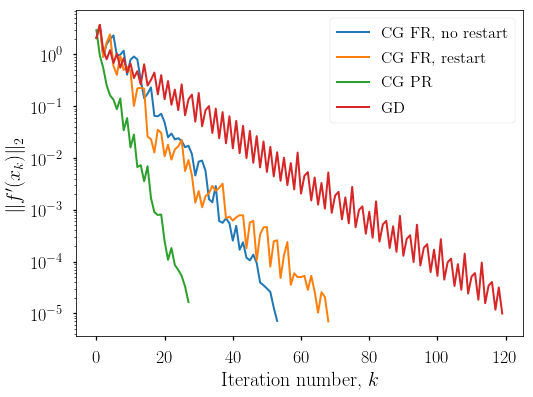

In [68]:
plt.figure(figsize=(8, 6))
plt.semilogy([np.linalg.norm(grad_f(x)) for x in cg_fr.get_convergence()], label=r"CG FR, no restart", linewidth=2)
plt.semilogy([np.linalg.norm(grad_f(x)) for x in cg_fr_rest.get_convergence()], label=r"CG FR, restart", linewidth=2)
plt.semilogy([np.linalg.norm(grad_f(x)) for x in scopt_cg_array], label=r"CG PR", linewidth=2)

plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label=r"GD", linewidth=2)
plt.legend(loc="best", fontsize=16)
plt.xlabel(r"Iteration number, $k$", fontsize=20)
plt.ylabel(r"$\|f'(x_k)\|_2$", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

#### Время выполнения

In [56]:
%timeit scopt.minimize(f, x0, method="CG", tol=tol, jac=grad_f, options={"maxiter": max_iter})
%timeit cg_fr.solve(x0, tol=tol, max_iter=max_iter)
%timeit cg_fr_rest.solve(x0, tol=tol, max_iter=max_iter)
%timeit gd.solve(x0, tol=tol, max_iter=max_iter)

12.5 ms ± 98.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
64.2 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
68.3 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
151 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Метод тяжёлого шарика (Б.Т. Поляк, 1964)

- Для квадратичной целевой функции зигзагообразное поведение градиентного спуска обусловлено неоднородностью направлений
- Учитывать предыдущие направления для поиска новой точки
- Метод тяжёлого шарика
$$
x_{k+1} = x_k - \alpha_k f'(x_k) + {\color{red}{\beta_k(x_k - x_{k-1})}}
$$

### Визуализация
Картинка [отсюда](https://www.princeton.edu/~yc5/ele538_optimization/lectures/accelerated_gradient.pdf) 
<img src="./heavy_ball.png" width=600 align="center">

### Сходимость

Пусть $f$ сильно выпукла с Липшицевым градиентом. Тогда для $\alpha_k = \frac{4}{(\sqrt{L} + \sqrt{\mu})^2}$ и $\beta_k = \max(|1 - \sqrt{\alpha_k L}|^2, |1 - \sqrt{\alpha_k \mu}|^2)$ справедлива следующая оценка сходимости

$$ 
\left\| \begin{bmatrix} x_{k+1} - x^* \\ x_k - x^* \end{bmatrix} \right\|_2
\leq 
\left( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k \left \|
\begin{bmatrix} x_1 - x^* \\ x_0 - x^* \end{bmatrix}
\right \|_2
$$

## Эксперименты

In [1]:
import liboptpy.base_optimizer as base
import numpy as np
import liboptpy.unconstr_solvers.fo as fo
import liboptpy.step_size as ss

class HeavyBall(base.LineSearchOptimizer):
    def __init__(self, f, grad, step_size, beta, **kwargs):
        super().__init__(f, grad, step_size, **kwargs)
        self._beta = beta
    
    def get_direction(self, x):
        self._current_grad = self._grad(x)
        return -self._current_grad

    def _f_update_x_next(self, x, alpha, h):
        if len(self.convergence) < 2:
            return x + alpha * h
        else:
            return x + alpha * h + self._beta * (x - self.convergence[-2])
    
    def get_stepsize(self):
        return self._step_size.get_stepsize(self._grad_mem[-1], self.convergence[-1], len(self.convergence))

### Тестовая функция

$$
f(x) = \frac{1}{2}x^{\top}Ax - b^{\top}x \to \min_x
$$

In [76]:
n = 50
A = np.random.randn(n, n)
A = A.T.dot(A)
x_true = np.random.randn(n)
b = A.dot(x_true)
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad = lambda x: A.dot(x) - b
A_eigvals = np.linalg.eigvalsh(A)
L = np.max(A_eigvals)
mu = np.min(A_eigvals)
print(L, mu)
alpha_opt = 4 / (np.sqrt(L) + np.sqrt(mu))**2 
beta_opt = np.maximum((1 - np.sqrt(alpha_opt * L))**2, 
                      (1 - np.sqrt(alpha_opt * mu))**2)
print(alpha_opt, beta_opt)

180.59562700157935 0.044597802423810916
0.02146887947327336 0.9390716071710745


In [87]:
methods = {
    "GD fixed": fo.GradientDescent(f, grad, ss.ConstantStepSize(1 / L)),
    "GD Armijo": fo.GradientDescent(f, grad, 
            ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
    "HB": HeavyBall(f, grad, ss.ConstantStepSize(1 / L), beta=0.9),
    "HB optimal": HeavyBall(f, grad, ss.ConstantStepSize(alpha_opt), beta = beta_opt),
    "CG": fo.ConjugateGradientQuad(A, b)
}
x0 = np.random.randn(n)
max_iter = 5000
tol = 1e-6

In [88]:
for m in methods:
    _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

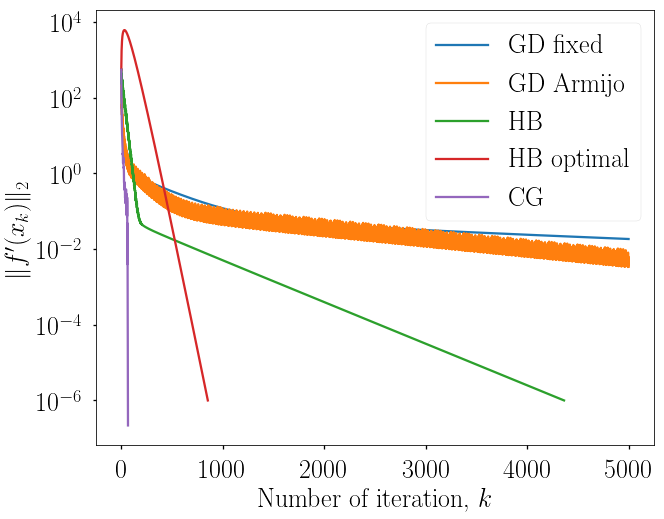

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)

figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in methods[m].get_convergence()], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

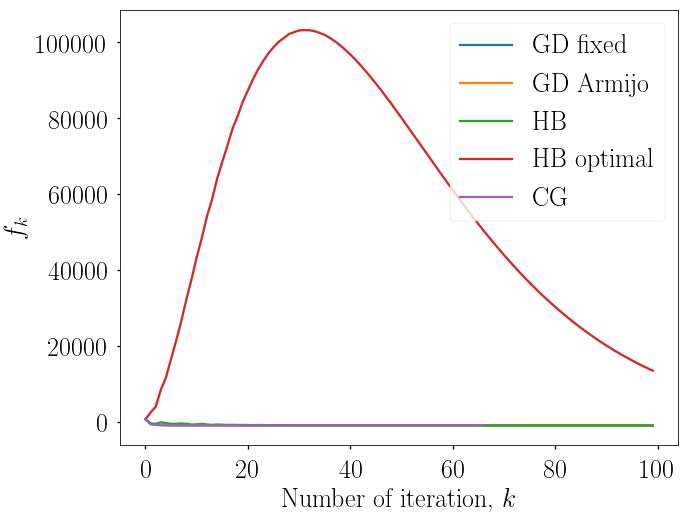

In [93]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)
for m in methods:
    plt.plot([f(x) for x in methods[m].get_convergence()[:100]], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f_k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

### Главное про метод тяжёлого шарика

- Двухшаговый метод
- Не обязательно монотонный
- Параметры зависят от неизвестных констант
- Решает проблему осцилляций для плохо обусловленных задач
- Сходимость для сильно выпуклых фукнкций сопадает с оптимальным порядком

## Ускоренный метод Нестерова

Одна из возможных форм записи 
\begin{equation*}
\begin{split}
& y_0 = x_0 \\
& x_{k+1} = y_k - \alpha_k f'(y_k)\\
& y_{k+1} = x_{k+1} + \frac{k}{k + 3} (x_{k+1} - x_k)
\end{split}
\end{equation*}

- Сравните с методом тяжёлого шарика
- также не обязательно монотонен
- Для любителей геометрии есть альтернативный метод под названием [geometric descent](https://arxiv.org/pdf/1506.08187.pdf) с такой же скоростью сходимости 

### Визуализация

<img src="nesterov_plot.png" width=600>

### Сходимость

- Выпуклые функции с Липшицевым градиентом

$$
f(x_k) - f^* \leq \frac{2L \|x_0 - x^*\|_2^2}{(k+1)^2} = \mathcal{O}(1/k^2)
$$

- Сильно выпуклые функции с Липшицевым градиентом

$$
f(x_k) - f^* \leq L \left(1 - \frac{1}{\sqrt{\kappa}} \right)^k \|x_k - x_0\|_2^2
$$

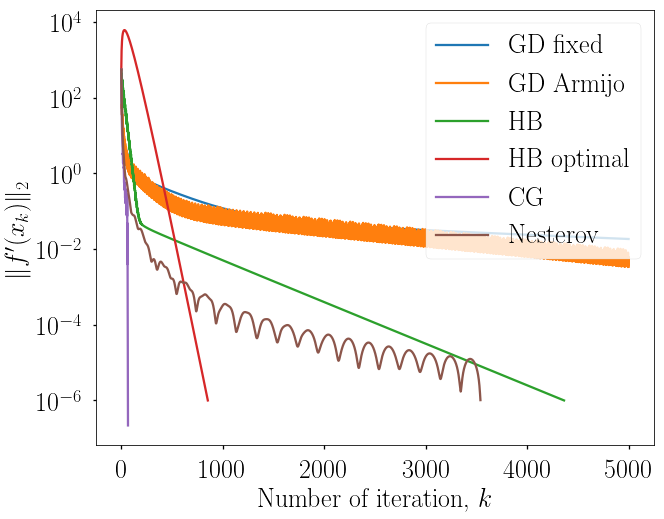

In [95]:
methods["Nesterov"] = fo.AcceleratedGD(f, grad, 
                                       ss.ConstantStepSize(1 / L))
methods["Nesterov"].solve(x0=x0, max_iter=max_iter, tol=tol)
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in 
                  methods[m].get_convergence()], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

### Комментарии

- Волнообразное поведение может быть подавлено с помощью рестартов
- Нелинейные композиции градиентов могут дать более быстрые на практике методы
- Как повлияет на скорость сходимости наличие шума в подсчёте градиентов будет рассказано в следующий раз :)

## Резюме

1. Сопряжённые направления
2. Метод сопряжённых градиентов
3. Метод тяжёлого шарика
4. Ускоренный градиентный метод 
5. Сходимость методов
6. Эксперименты